Now that we have build our model, let's make future predictions. As a reminder, our plan of action was as follows:

1. Perform EDA on the dataset to extract valuable insight about the process generating the time series **(COMPLETED)**.
2. Build a baseline model (univariable model without exogenous variables) for benchmarking purposes **(COMPLETED)**.
3. Build a univariate model with all exogenous variables to check best possible performance **(COMPLETED)**.
4. Evaluate the model with exogenous variables and discuss any potential issues **(COMPLETED)**.
5. Overcome issues identified above **(COMPLETED)**.
6. Make future predictions with the best model. **(Covered in this notebook)**
7. Replicate flow with Automated Time Series Modeling (AutoML)

In [10]:
def what_is_installed():
    from pycaret import show_versions
    show_versions()

try:
    what_is_installed()
except ModuleNotFoundError:
    !pip install pycaret-ts-alpha
    what_is_installed()


System:
    python: 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
executable: C:\Users\Nikhil\.conda\envs\pycaret_dev_sktime_0p10p0\python.exe
   machine: Windows-10-10.0.19044-SP0

Python dependencies:
          pip: 21.2.2
   setuptools: 60.8.2
      pycaret: 3.0.0
      sklearn: 1.0.2
       sktime: 0.10.1
  statsmodels: 0.12.2
        numpy: 1.21.5
        scipy: 1.7.3
       pandas: 1.4.2
   matplotlib: 3.5.1
       plotly: 5.5.0
       joblib: 1.0.1
        numba: 0.55.1
       mlflow: 1.23.1
     lightgbm: 3.3.2
      xgboost: Not installed
     pmdarima: 1.8.4
        tbats: Installed but version unavailable
      prophet: 1.0
      tsfresh: Not installed


In [11]:
import numpy as np
import pandas as pd
from pycaret.datasets import get_data
from pycaret.time_series import TSForecastingExperiment

In [3]:
#### Global Figure Settings for notebook ----
global_fig_settings = {"renderer": "notebook", "width": 1000, "height": 600}

In [4]:
data = get_data("airquality", verbose=False)
data["index"] = pd.to_datetime(data["Date"] + " " + data["Time"])
data.drop(columns=["Date", "Time"], inplace=True)
data.replace(-200, np.nan, inplace=True)
data.fillna(method="ffill", inplace=True)
data.set_index("index", inplace=True)

exog_vars = ['NOx(GT)', 'PT08.S3(NOx)', 'RH']
data = data[exog_vars]
data.head()

,NOx(GT),PT08.S3(NOx),RH
index,,,
2004-03-10 18:00:00,166.0,1056.0,48.9
2004-03-10 19:00:00,103.0,1174.0,47.7
2004-03-10 20:00:00,131.0,1140.0,54.0
2004-03-10 21:00:00,172.0,1092.0,60.0
2004-03-10 22:00:00,131.0,1205.0,59.6


## Step 6: Making Future Predictions

### Step 6A: Get future exogenous variable values using forecasting

In [5]:
exog_exps = []
exog_models = []
for exog_var in exog_vars:
    exog_exp = TSForecastingExperiment()
    exog_exp.setup(
        data=data[exog_var], fh=48,
        # numeric_imputation_target="ffill",
        fig_kwargs=global_fig_settings, session_id=42
    )

    # Users can customize how to model future exogenous variables i.e. add
    # more steps and models to potentially get better models at the expense
    # of higher modeling time.
    best = exog_exp.compare_models(
        sort="mase", include=["arima", "ets", "exp_smooth", "theta", "lightgbm_cds_dt",]        
    )
    final_exog_model = exog_exp.finalize_model(best)

    exog_exps.append(exog_exp)
    exog_models.append(final_exog_model)

# Step 2: Get future predictions for exog variables ----
future_exog = [
    exog_exp.predict_model(exog_model)
    for exog_exp, exog_model in zip(exog_exps, exog_models)
]
future_exog = pd.concat(future_exog, axis=1)
future_exog.columns = exog_vars

,Model,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2,TT (Sec)
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,11.0836,13.5879,0.2862,0.2304,1.1990,1.0486,-0.9502,1.3367
exp_smooth,Exponential Smoothing,13.7510,15.4140,0.3037,0.2478,1.4890,1.1904,-0.4248,0.7167
arima,ARIMA,14.4696,17.7412,0.3539,0.2739,1.5657,1.3693,-2.1191,1.6567
theta,Theta Forecaster,17.6420,19.2958,0.3713,0.2986,1.9102,1.4902,-1.2629,0.4300
ets,ETS,31.8652,34.3839,0.6295,0.4585,3.4504,2.6557,-6.1733,7.8700


In [6]:
future_exog

,NOx(GT),PT08.S3(NOx),RH
2005-04-04 15:00,262.1091,656.1044,14.5065
2005-04-04 16:00,297.1918,638.6659,15.6333
2005-04-04 17:00,325.5872,596.7227,17.5673
2005-04-04 18:00,259.7444,556.0672,22.7364
2005-04-04 19:00,425.2039,534.2108,28.3385
2005-04-04 20:00,403.5829,553.1982,33.7580
2005-04-04 21:00,275.5622,611.5993,37.0870
2005-04-04 22:00,266.8754,652.8857,39.7600
2005-04-04 23:00,198.3008,662.6246,41.3155
2005-04-05 00:00,140.6534,680.4221,42.4415


### Step 6B: Load Model and make future predcitons for the target variable

In [7]:
exp_future = TSForecastingExperiment()

In [8]:
final_slim_model = exp_future.load_model("final_slim_model")

Transformation Pipeline and Model Successfully Loaded


<AxesSubplot:>

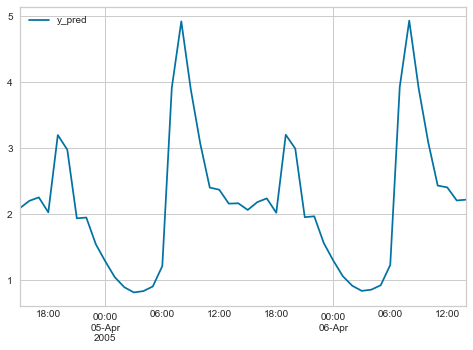

In [9]:
future_preds = exp_future.predict_model(final_slim_model, X=future_exog)
future_preds.plot()